[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amgp-upm/xray_project/blob/main/dicom_files.ipynb)

In [43]:
import pandas as pd
import numpy as np
try:
    import pydicom
except:
    ! pip install pydicom
    import pydicom
    
import matplotlib.pyplot as plt
import os
import glob

In [44]:
filename = '/mnt/MI_LUNG/vinbigdata/train/a9f17d3eb4a8221c3ef0dd12bfec0ba0.dicom'

In [45]:
dcm = pydicom.dcmread(filename)

In [46]:
dcm

/home/agarcia/miniconda3/envs/pytorch/lib/python3.7/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'a9f17d3eb4a8221c3ef0dd12bfec0ba0'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: a9f17d3eb4a8221c3ef0dd12bfec0ba0
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'O'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 2430
(0028, 0011) Columns                             US: 1994
(0028, 0030) Pixel Spacing            

In [47]:
print(os.path.basename(filename))
print(f'Patient Gender.......: {dcm.PatientSex}')
print(f'Bits Stored.......: {dcm.BitsStored}')

if 'PixelData' in dcm:
    rows = int(dcm.Rows)
    cols = int(dcm.Columns)
    print(f'Image size.......: {rows} x {cols}, {len(dcm.PixelData)} bytes')
    if 'PixelSpacing' in dcm:
        print(f'Pixel spacing....: {dcm.PixelSpacing}')

a9f17d3eb4a8221c3ef0dd12bfec0ba0.dicom
Patient Gender.......: O
Bits Stored.......: 12
Image size.......: 2430 x 1994, 9690840 bytes
Pixel spacing....: [0.175, 0.175]


In [48]:
img = dcm.pixel_array

print(f'Max value: {np.max(img)}')
print(f'Max value: {np.min(img)}')

Max value: 4036
Max value: 0


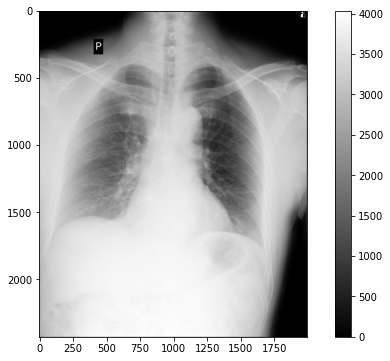

In [53]:
plt.figure(figsize=(10,6))
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

In [54]:
df = pd.read_csv('/mnt/MI_LUNG/vinbigdata/train.csv')
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [55]:
df[df['image_id'] == os.path.splitext(os.path.basename(filename))[0]]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
3025,a9f17d3eb4a8221c3ef0dd12bfec0ba0,No finding,14,R5,NaN,NaN,NaN,NaN
4988,a9f17d3eb4a8221c3ef0dd12bfec0ba0,No finding,14,R11,NaN,NaN,NaN,NaN
22653,a9f17d3eb4a8221c3ef0dd12bfec0ba0,No finding,14,R1,NaN,NaN,NaN,NaN


In [ ]:
## TODO: visualize data

## Pytorch

In [56]:
import torch
from torchvision import models

In [95]:
import torch
from torch import nn
from torchvision import models, transforms


class FeatureExtractor(nn.Module):
    def __init__(self, model_name: str, pretrained: bool = True) -> None:
        super().__init__()
        self.model_name = model_name
        self.pretrained = pretrained
        self.model = self._get_model()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.model(x)
        features_pool = self.pool(features)
        features_flatten = self.flatten(features_pool)
        return features_flatten

    def _get_model(self) -> nn.Module:
        if self.model_name == 'resnet18':
            model = models.resnet18(pretrained=self.pretrained)
            #print(*list(model.children())[:-2])
            model = nn.Sequential(*list(model.children())[:-2])
        elif self.model_name == 'resnet34':
            model = models.resnet34(pretrained=self.pretrained)
            #print(*list(model.children())[:-2])
            model = nn.Sequential(*list(model.children())[:-2])
        elif self.model_name == 'resnet50':
            model = models.resnet50(pretrained=self.pretrained)
            #print(*list(model.children())[:-2])
            model = nn.Sequential(*list(model.children())[:-2])
        else:
            raise ValueError(f'Invalid model name: {self.model_name}')
        return model

In [114]:
model = FeatureExtractor('resnet18')
x = torch.rand(1, 3, 256, 256)

feats = model(x)
feats = feats.detach().cpu().numpy()[0]

feats.shape[0]

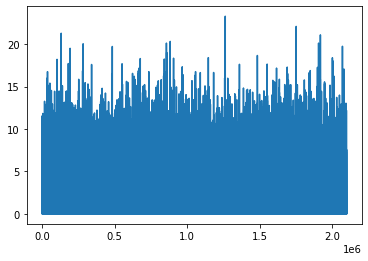

In [115]:
plt.plot(range(feats.shape[0]), feats)
plt.show()

In [ ]:
# TODO: generate features of the images
# It is necessary to resize images and padding